In [ ]:
################################################################################
# 1) Mount Drive, Check GPU, and Check RAM
################################################################################

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Check GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if 'failed' in gpu_info:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Thu Apr 10 19:20:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f'Your runtime has {ram_gb:.1f} gigabytes of available RAM\n')
if ram_gb < 20:
    print('Not using a high-RAM runtime.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
################################################################################
# 2) Installs (if needed; adjust packages as necessary)
################################################################################

!pip -qqq install pydub
!pip -qqq install tensorboard
!pip -qqq install visualkeras
!pip -qqq install --upgrade keras
!pip -qqq install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
################################################################################
# 3) Imports
################################################################################

import os
import math
import numpy as np
import librosa
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import random

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Audio
from IPython.display import Audio
from scipy.io import wavfile
import scipy
import soundfile as sf
from pydub import AudioSegment

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

# Visualization
import visualkeras


In [ ]:
################################################################################
# 4) Define Base Directories
################################################################################

base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'STFT_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

# Check if the directories exist
if not os.path.exists(train_dir):
    print(f"Train directory does not exist: {train_dir}")
if not os.path.exists(test_dir):
    print(f"Test directory does not exist: {test_dir}")

# List some files to confirm
print("Listing some files in train_dir:", os.listdir(train_dir)[:10])
print("LENS train_dir:", len(os.listdir(train_dir)))
print("Listing some files in test_dir:", os.listdir(test_dir)[:10])
print("LENS test_dir:", len(os.listdir(test_dir)))


Listing some files in train_dir: ['Explosion', 'Emergency_alarm', 'Gun_Shots', 'glass_breaking', 'thunderstorm', 'dog', 'wind', 'Earthquake', 'Flood', 'Tsunami']
LENS train_dir: 13
Listing some files in test_dir: ['Gun_Shots', 'Emergency_alarm', 'Explosion', 'dog', 'glass_breaking', 'thunderstorm', 'wind', 'Flood', 'Earthquake', 'Tsunami']
LENS test_dir: 13


In [ ]:
################################################################################
# 5) Data Generators
################################################################################

# You can adjust your augmentations here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
height = 128
width = 128   # Typically you'd want your spectrogram images to have a consistent shape
channels = 3  # 3 if color images

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Found {train_generator.samples} images for training.")
print(f"Found {test_generator.samples} images for testing.")

Found 3015 images belonging to 13 classes.
Found 1351 images belonging to 13 classes.
Found 3015 images for training.
Found 1351 images for testing.


In [ ]:
################################################################################
# 7) Load Pretrained VGG19 (with Frozen Layers)
################################################################################

# Include top=False means we remove the final dense layers,
# so we can replace them for our own classification.
vgg = VGG19(
    input_shape=(height, width, channels),
    weights="imagenet",
    include_top=False
)

# Freeze pretrained layers
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │       106,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,130,893 (76.79 MB)

 Trainable params: 106,509 (416.05 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


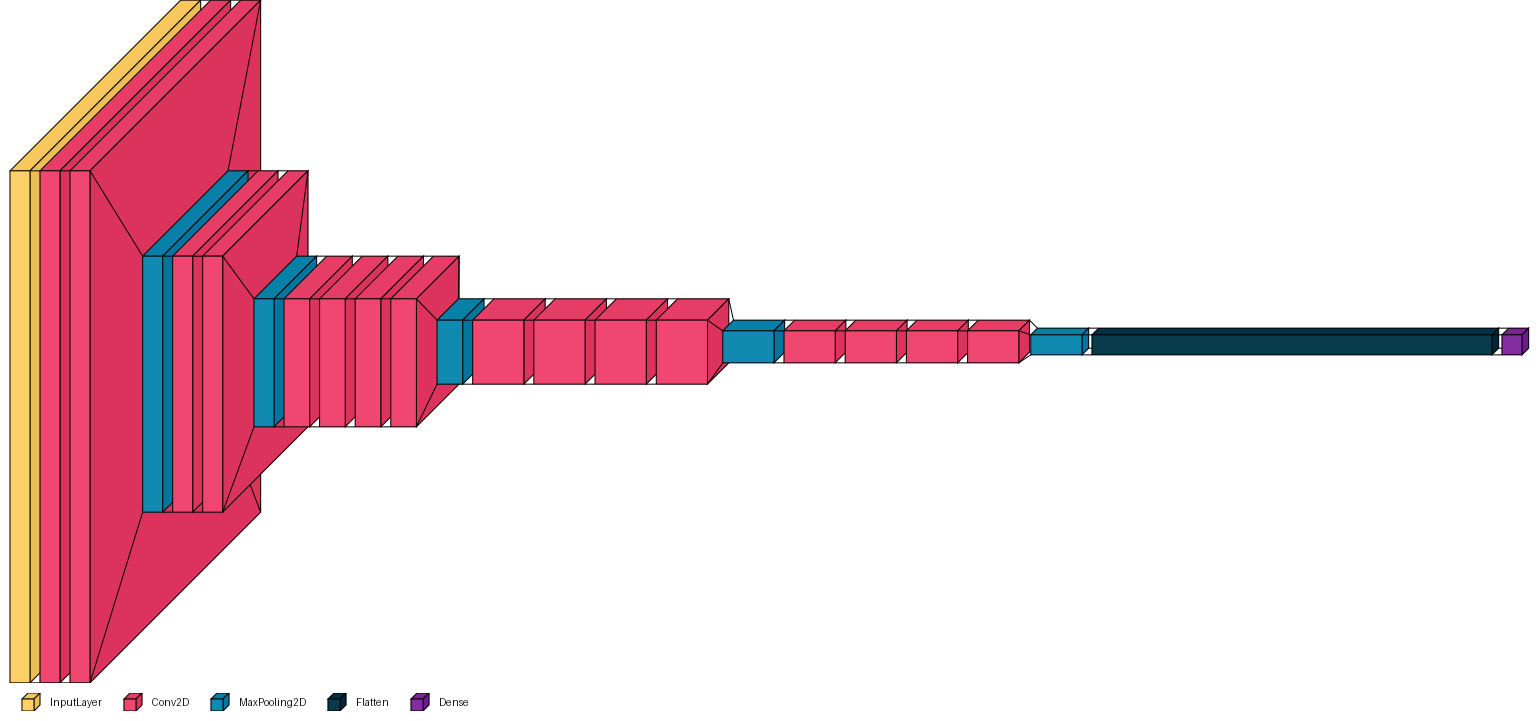

In [ ]:
################################################################################
# 8) Visualize Model
################################################################################

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
visualkeras.layered_view(model, legend=True)  # Only works in certain environments


In [ ]:
################################################################################
# 9) Compile the Model
################################################################################
# Import necessary metrics
from tensorflow.keras.metrics import Precision, Recall

# Assuming f1_score_metric is a custom function, ensure it's defined

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        # If f1_score_metric is a function, call it like this:
        # f1_score_metric
        # Otherwise, if it's a metric from tf.keras.metrics, import and use as above.
    ]
)

In [ ]:
################################################################################
# 10) Fit the Model (Single Training Loop)
################################################################################

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode="min",
    patience=30,
    restore_best_weights=True
)

epochs = 150  # Adjust as needed

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping],
    shuffle=True
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 1723s 18s/step - accuracy: 0.3539 - loss: 2.0843 - precision: 0.7043 - recall: 0.1281 - val_accuracy: 0.6336 - val_loss: 1.3395 - val_precision: 0.9328 - val_recall: 0.3183
Epoch 2/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 56s 591ms/step - accuracy: 0.5970 - loss: 1.3059 - precision: 0.8432 - recall: 0.3910 - val_accuracy: 0.6958 - val_loss: 1.1503 - val_precision: 0.9081 - val_recall: 0.4315
Epoch 3/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 56s 587ms/step - accuracy: 0.6532 - loss: 1.1405 - precision: 0.8844 - recall: 0.4661 - val_accuracy: 0.6825 - val_loss: 1.1597 - val_precision: 0.8646 - val_recall: 0.4678
Epoch 4/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 56s 588ms/step - accuracy: 0.6870 - loss: 1.0188 - precision: 0.8715 - recall: 0.5096 - val_accuracy: 0.6839 - val_loss: 1.0232 - val_precision: 0.8492 - val_recall: 0.5337
Epoch 5/150
95/95 ━━━━━━━━━━━━━━━━━━━━ 57s 596ms/step - accuracy: 0.7047 - loss: 0.9606 - precision: 0.8753 - recall: 0.5585 - val_accuracy: 0.7165 - va

In [ ]:
################################################################################
# 11) Evaluate & Save
################################################################################

# Evaluate on the test set
scores = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")
print(f"Test Precision: {scores[2]:.4f}")
print(f"Test Recall: {scores[3]:.4f}")


# (Optional) Generate a classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Save the model
save_path = '/content/drive/MyDrive/VGG19/STFT_Folder/al-emadi_vgg19_stft_new.keras'
model.save(save_path)
print(f"Model saved to: {save_path}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 332ms/step - accuracy: 0.7966 - loss: 0.8142 - precision: 0.8540 - recall: 0.7455
Test Loss: 0.5554
Test Accuracy: 0.8386
Test Precision: 0.8866
Test Recall: 0.8046
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step
                   precision    recall  f1-score   support

      Dam Failure       0.50      0.15      0.24        13
       Earthquake       0.89      0.84      0.86       185
  Emergency_alarm       0.94      0.91      0.93       124
        Explosion       0.70      0.56      0.62        78
            Flood       0.76      0.86      0.81        76
        Gun_Shots       0.89      0.91      0.90        35
          Tsunami       0.73      0.69      0.71        89
Volcanic Eruption       0.77      0.64      0.70       111
         Wildfire       0.99      0.99      0.99       400
              dog       0.83      0.77      0.80        56
   glass_breaking       0.62      0.92      0.74        60
     thunderstorm       0.55      0.71      0.62     

In [ ]:
################################################################################
# 12) MAKE PREDICTIONS & CONFUSION MATRIX
################################################################################

# Import confusion_matrix
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 330ms/step

Confusion Matrix:
[[  2   1   0   1   1   0   3   0   2   0   2   0   1]
 [  1 155   0   3   1   2   2   6   0   1   8   5   1]
 [  0   2 113   1   2   0   0   0   0   4   0   1   1]
 [  1   2   3  44   3   0   4   6   0   0   7   5   3]
 [  0   0   0   0  65   0   4   0   0   0   6   1   0]
 [  0   0   0   0   1  32   0   0   0   0   1   1   0]
 [  0   2   1   1   9   0  61   3   1   0   1   7   3]
 [  0   8   0   7   0   0   6  71   0   1   2  10   6]
 [  0   0   0   1   0   0   0   1 398   0   0   0   0]
 [  0   0   3   1   0   0   0   0   0  43   7   2   0]
 [  0   0   0   1   0   1   0   0   0   2  55   1   0]
 [  0   3   0   2   0   1   0   3   0   0   0  41   8]
 [  0   2   0   1   3   0   3   2   0   1   0   1  53]]

Classification Report:
                   precision    recall  f1-score   support

      Dam Failure       0.50      0.15      0.24        13
       Earthquake       0.89      0.84      0.86       185
  Emergency_alarm    

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 325ms/step


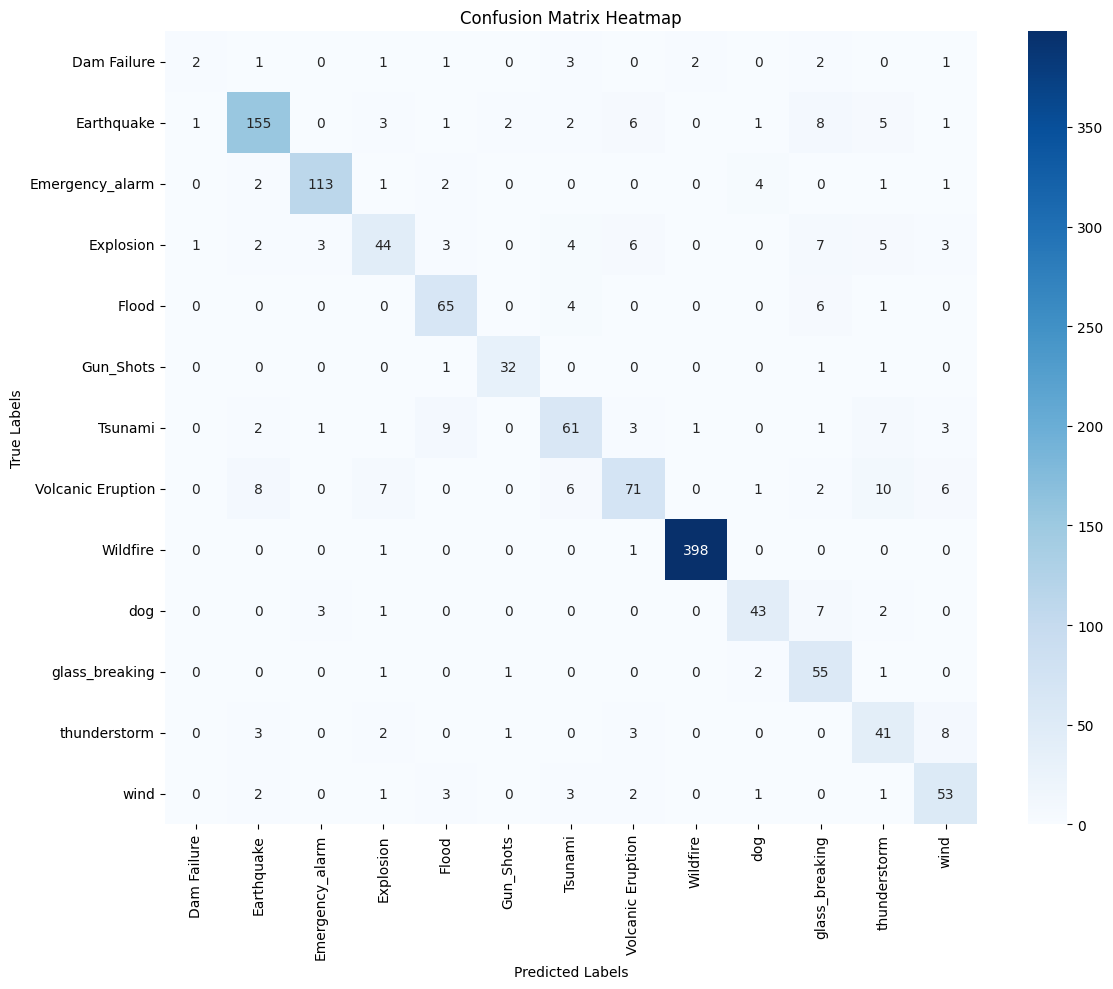


Classification Report:
                   precision    recall  f1-score  support
Dam Failure         0.500000  0.153846  0.235294     13.0
Earthquake          0.885714  0.837838  0.861111    185.0
Emergency_alarm     0.941667  0.911290  0.926230    124.0
Explosion           0.698413  0.564103  0.624113     78.0
Flood               0.764706  0.855263  0.807453     76.0
Gun_Shots           0.888889  0.914286  0.901408     35.0
Tsunami             0.734940  0.685393  0.709302     89.0
Volcanic Eruption   0.771739  0.639640  0.699507    111.0
Wildfire            0.992519  0.995000  0.993758    400.0
dog                 0.826923  0.767857  0.796296     56.0
glass_breaking      0.617978  0.916667  0.738255     60.0
thunderstorm        0.546667  0.706897  0.616541     58.0
wind                0.697368  0.803030  0.746479     66.0


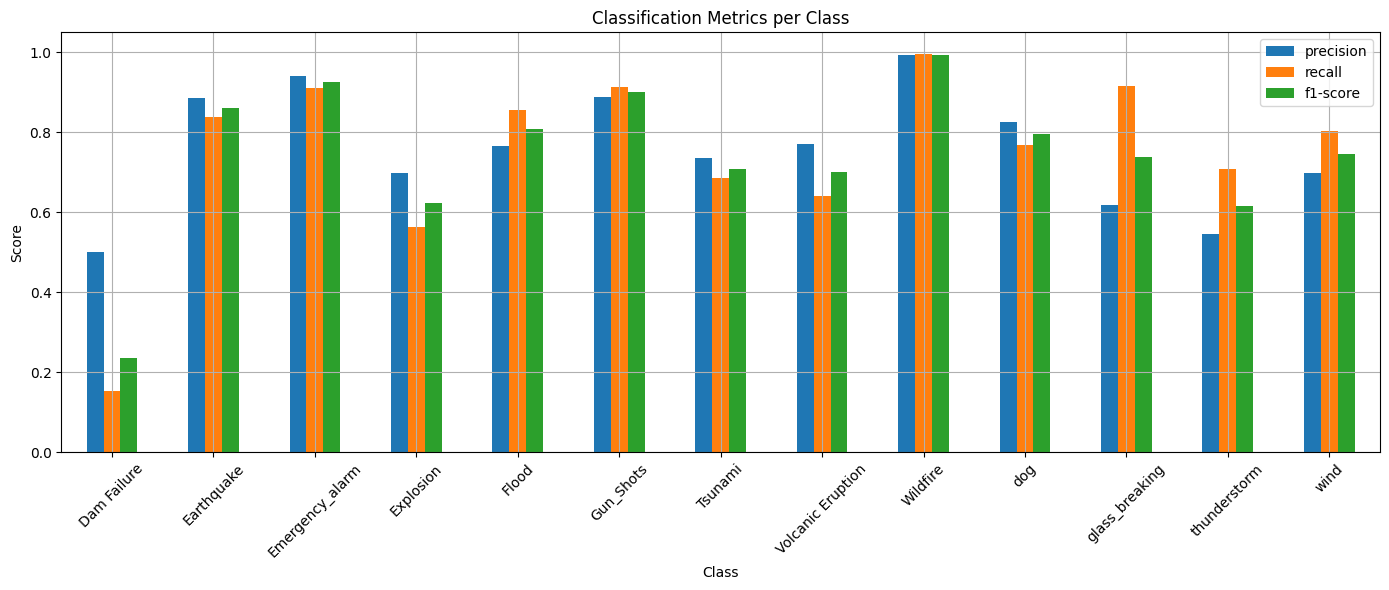

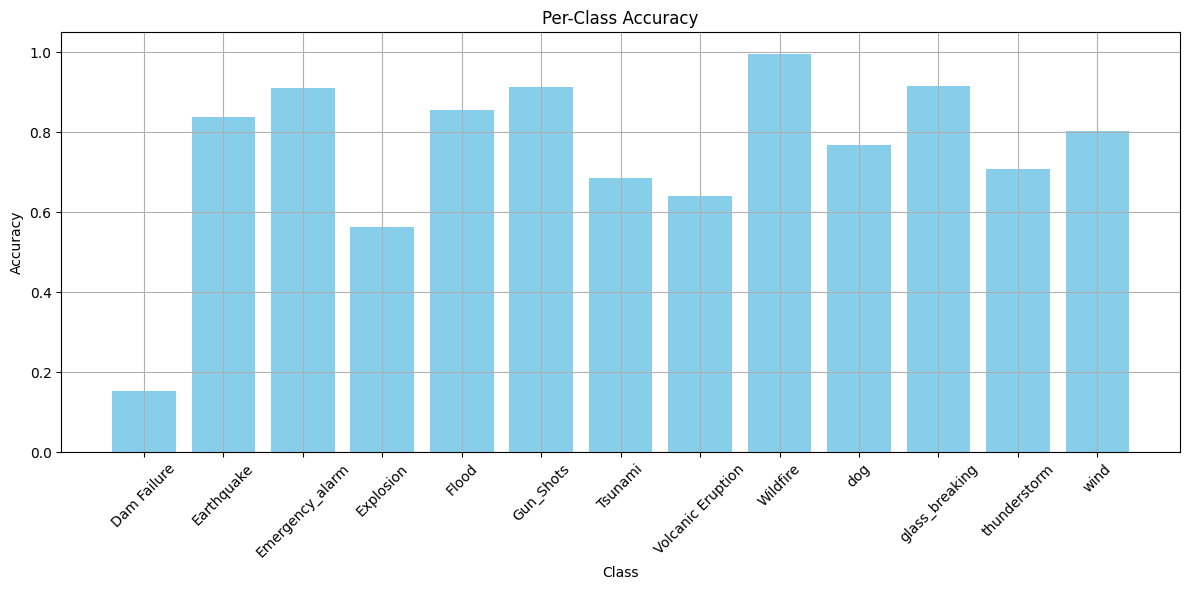

In [ ]:
################################################################################
# 12) MAKE PREDICTIONS & CONFUSION MATRIX (with Visualizations)
################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True class indices and labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3, :]  # remove accuracy, macro avg, weighted avg
print(report_df)

# Plot precision, recall, f1-score per class
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(14, 6))
plt.title('Classification Metrics per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Per-Class Accuracy Calculation
class_accuracy = {}
for i, label in enumerate(class_labels):
    class_indices = np.where(true_classes == i)[0]
    correct_preds = np.sum(predicted_classes[class_indices] == i)
    class_accuracy[label] = correct_preds / len(class_indices) if len(class_indices) > 0 else 0.0

# Plot Per-Class Accuracy
plt.figure(figsize=(12, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 325ms/step


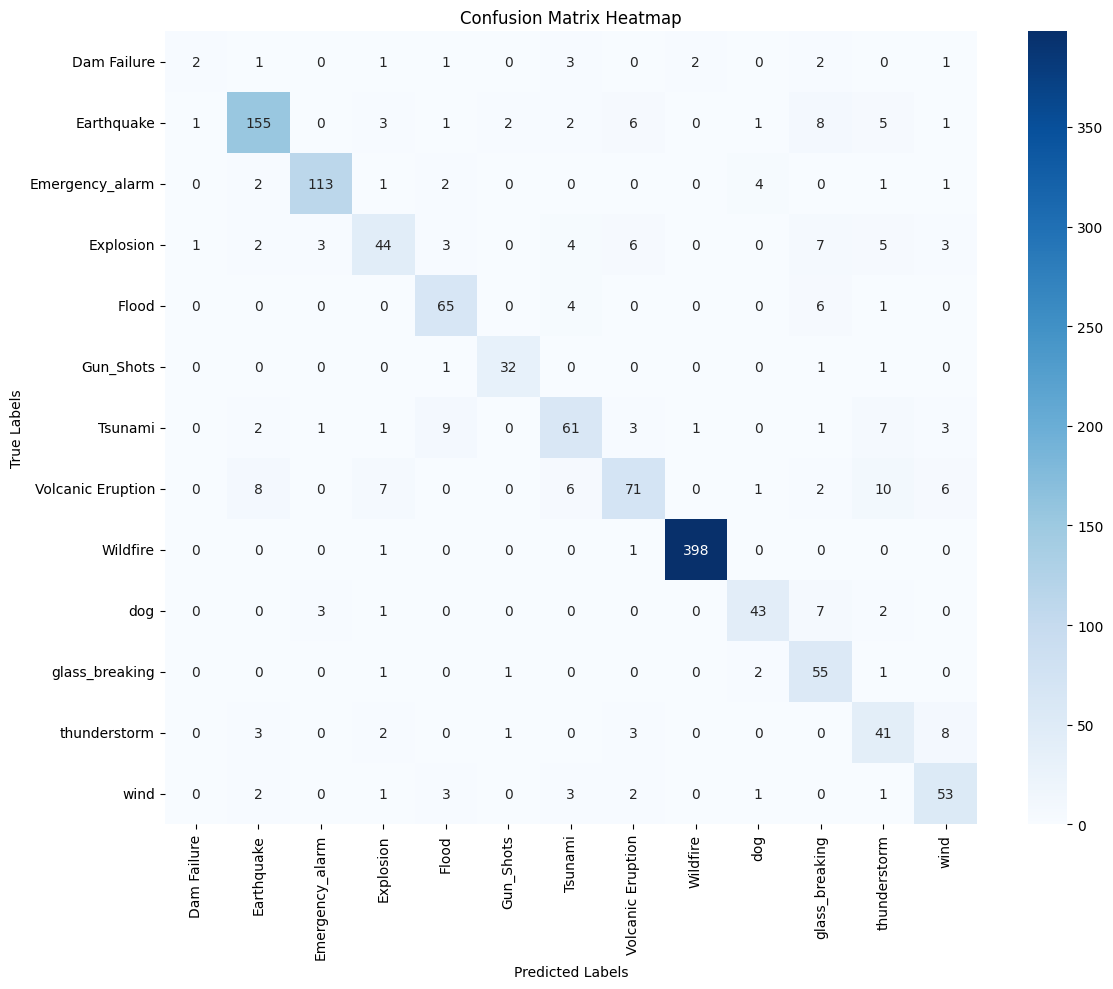


Classification Report:
                   precision    recall  f1-score  support
Dam Failure         0.500000  0.153846  0.235294     13.0
Earthquake          0.885714  0.837838  0.861111    185.0
Emergency_alarm     0.941667  0.911290  0.926230    124.0
Explosion           0.698413  0.564103  0.624113     78.0
Flood               0.764706  0.855263  0.807453     76.0
Gun_Shots           0.888889  0.914286  0.901408     35.0
Tsunami             0.734940  0.685393  0.709302     89.0
Volcanic Eruption   0.771739  0.639640  0.699507    111.0
Wildfire            0.992519  0.995000  0.993758    400.0
dog                 0.826923  0.767857  0.796296     56.0
glass_breaking      0.617978  0.916667  0.738255     60.0
thunderstorm        0.546667  0.706897  0.616541     58.0
wind                0.697368  0.803030  0.746479     66.0


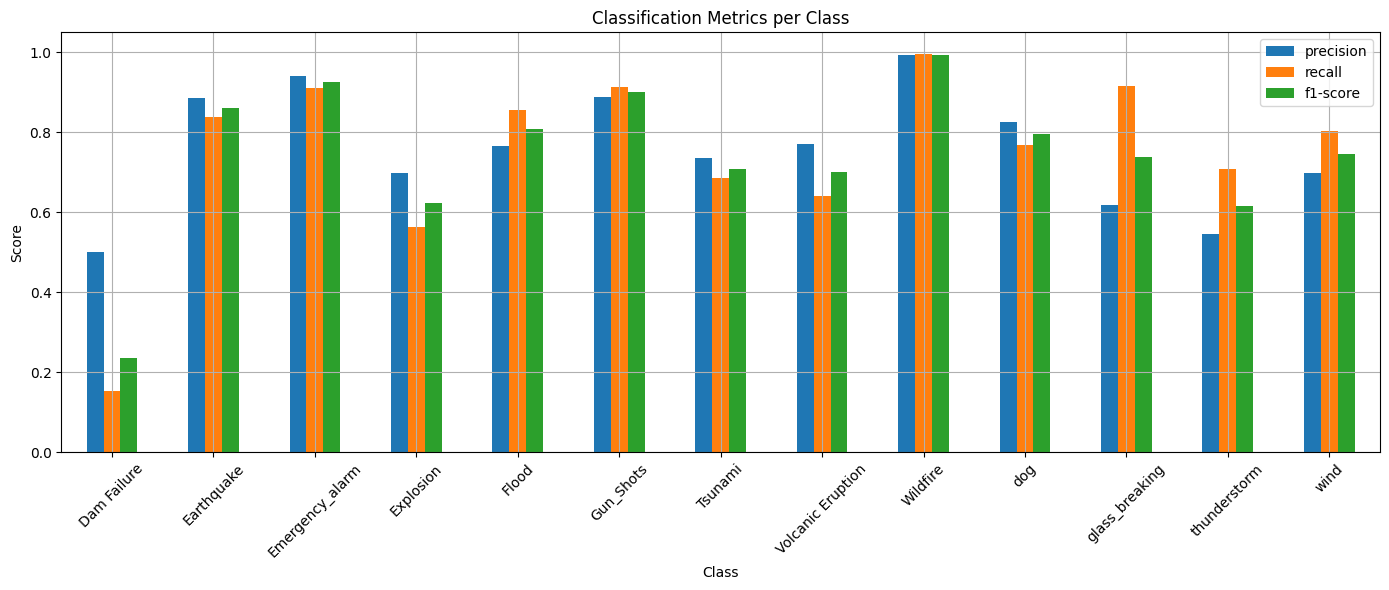

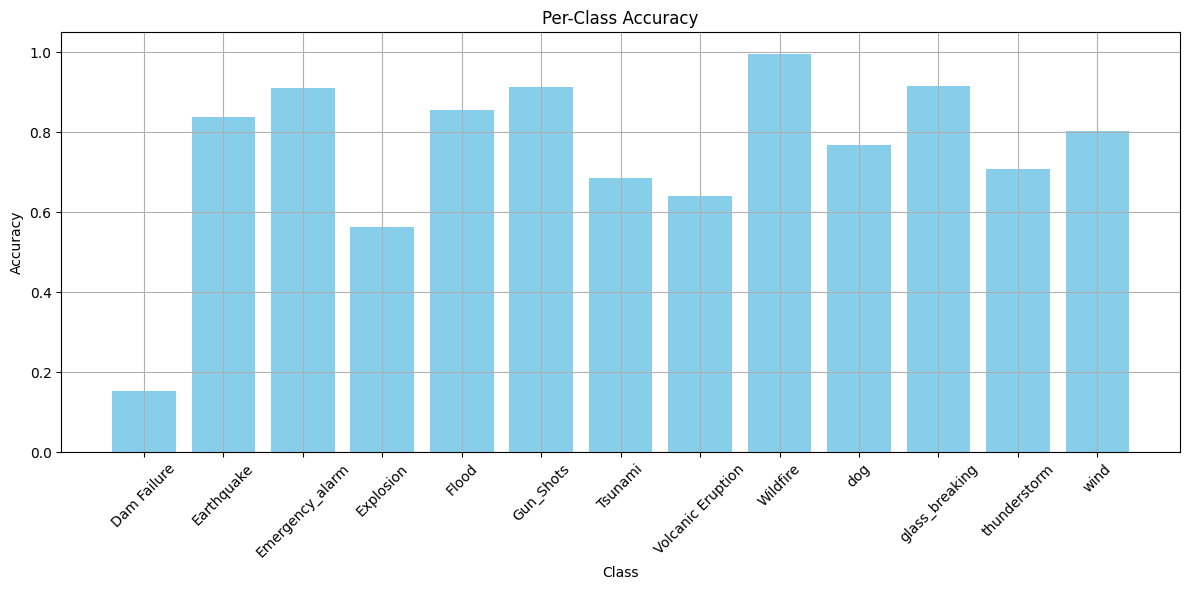

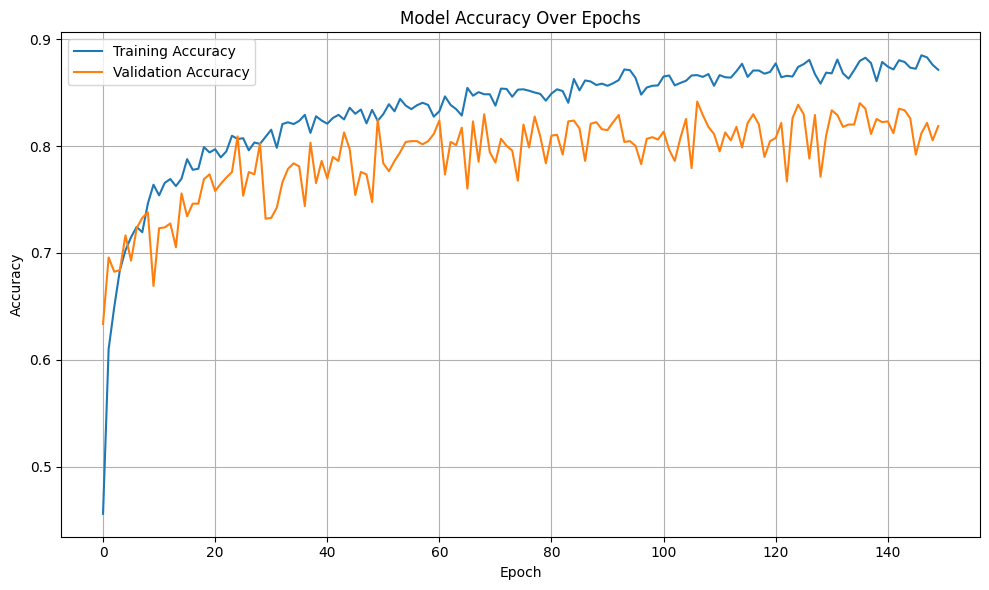

In [ ]:
################################################################################
# 12) MAKE PREDICTIONS & CONFUSION MATRIX (with Visualizations)
################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True class indices and labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3, :]  # remove accuracy, macro avg, weighted avg
print(report_df)

# Plot precision, recall, f1-score per class
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(14, 6))
plt.title('Classification Metrics per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Per-Class Accuracy Calculation
class_accuracy = {}
for i, label in enumerate(class_labels):
    class_indices = np.where(true_classes == i)[0]
    correct_preds = np.sum(predicted_classes[class_indices] == i)
    class_accuracy[label] = correct_preds / len(class_indices) if len(class_indices) > 0 else 0.0

# Plot Per-Class Accuracy
plt.figure(figsize=(12, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

################################################################################
# 13) Plot Training & Validation Accuracy Over Epochs
################################################################################

if 'history' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available. Make sure you trained the model with history = model.fit(...)")
